# Applied statistics  2018
## Solution to exam set 
## January, 2019
### Christian Holm Christensen

### Niels Bohr Institute

Let's load some modules etc. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats
import scipy.optimize
import scipy.constants
import sys
sys.path.append('..')
import nbi_stat as nbi 
import sympy as sy
import matplotlib.pyplot as plt
import IPython as ipy
import re
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
sy.init_printing()
nbi.css_styling()

In [2]:
def printRes(quant,value,errors,nsig,expo=None,unit=None):
    return ipy.display.Math(nbi.formatResult(value,errors,nsig,
                                             name=quant,expo=expo,unit=unit,
                                             latex=True))

# Distributions and probabilities

## Roulette

Peter plays black on the Roulette which carries a probability of $p=18/37$.   The probability of $n$ success out of $N$ trials is given by the Binomial distribution.  Thus 

- The probability of 25 success in 50 games is then 

$$P(n=25) = f_{\mathrm{Binomal}}(25,p=18/37)\quad,$$

In [3]:
printRes("P(n=25)",sp.stats.binom.pmf(25,50,18/37)*100,None,3,unit="\%")

<IPython.core.display.Math object>

- The probability of 26 success or more in the same number of tries is given by 

$$P(n\ge26)=\sum_{n=26}^{50} P(n) = \sum_{n=26}^{50} f_{\mathrm{Binomial}}(n;50,18/37) = 1-F_{\mathrm{Binomial}}(25;50,18/37)\quad,$$

where $F_{\mathrm{Binomial}}$ is the cumulative distribution function of a Bionomal random variable.  

In [4]:
printRes("P(n\ge26)",sp.stats.binom.sf(25,50,18/37)*100,None,3,unit="\%")

<IPython.core.display.Math object>

## Gaussian

The probability density function (PDF) of a normal distributed random variable $X\sim N(\mu,\sigma)$ with location parameters $\mu,\sigma$ is given y 

$$f_{N}(x;\mu,\sigma) \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac12\frac{(x-\mu)^2}{\sigma^2}}\quad.$$

The probability for a value in the interval $[a,b]$ is given by 

$$P(a<x<b)=\int_a^b\mathrm{d}x f_{N}(x;\mu,\sigma) = F_N(b)-F_N(a)\quad,$$

where $F_N$ is the cumulative distribution function of $X$.  Furthermore, since $f_N$ is symmetric about $\mu$, we have that 

$$P(\mu-a<x<\mu-b) = P(\mu+b<x<\mu+a)\quad,$$ 

and thus the probability of $X$ in $I=[\mu-2.5\sigma,\mu-1.2\sigma]\cup[\mu+1.2\sigma,\mu+2.5\sigma]$ is given by 

$$P(x\in I) = 2\left(F_N(\mu+2.5\sigma)-F_N(\mu+1.2\sigma)\right)\quad.$$

In [5]:
printRes("P(x\in I)",2*(sp.stats.norm.cdf(2.5)-sp.stats.norm.cdf(1.2))*100,
         None,3,unit="\%")

<IPython.core.display.Math object>

Or symbolically

In [6]:
x,mu,sigma = sy.symbols("x mu sigma")
(2*sy.integrate(1/(sy.sqrt(2*sy.pi)*sigma)*sy.exp(-1/2*((x-mu)**2/sigma**2)),
                (x,mu+1.2*sigma,mu+2.5*sigma)))\
    .evalf().round(3)*100*sy.physics.units.Unit(r'\%','percent')

## Surgical mistaktes

Since the number of operations performed in Danish hospital is in principle unlimited, and since the probability of (grave) mistakes is relatively small and independent, the probability of the number $n$ of mistakes should be Poissonian.  

A critical day is characterised as a day with $n\ge8$.  Given 22 critical days of the 365.24 days a year we have that 

\begin{align*}
\sum_{n=9}^{\infty} f_{P}(n;\lambda)&=1-F_{P}(8;\lambda)=\frac{22}{365.24}\\
1-\frac{22}{365.24} - F_P(8;\lambda) &= 0\quad,
\end{align*}

which we solve for $\lambda$

In [7]:
printRes('\lambda',
         sp.optimize.brentq(lambda lam : 1-22/365.24-sp.stats.poisson.cdf(8,lam),0,1e9),
         None,3)

<IPython.core.display.Math object>

# Propagation of uncertainties

*Note*: We are _not_ propagating _errors_, which would truly be an _error_.

## Tumor depth

We have 4 measurements of a depth of a tumor _with_ uncertainties

In [8]:
d_1 = [2.05, 2.61, 2.46, 2.48]
e_1 = [0.11, 0.10, 0.13, 0.12]

Taking $w_i=1/\delta_i^2$ as the weights, we find a weighted average 

$$
\bar d_1^w = \frac{\sum_i w_i x_i}{\sum_i w_i} \pm \frac{1}{\sqrt{\sum_i w_i}}
= \frac{\sum_i \tfrac1{\delta_i^2}x_i}{\sum_i \tfrac1{\delta_i^2}} \pm
\frac1{\sqrt{\sum_i \tfrac1{\delta_i^2}}}
$$

of these measurements to be 

In [9]:
wa_1 = np.average(d_1,weights=1/np.array(e_1)**2)
ew_1 = 1/np.sqrt((1/np.array(e_1)**2).sum())
printRes(r'\bar d^w',wa_1,[ew_1],1)
# d = sy.Symbol('')
# wa_1*d+pm*ew_1

<IPython.core.display.Math object>

Calculating the $\chi^2$ of the observations wrt. to the weighted average then gives 

In [10]:
chi2_1,nu_1 = nbi.chi2nu(np.arange(len(d_1)),d_1,lambda x,*p: wa_1, [0], e_1)
printRes(r'\chi^2/\nu={:.1f}/{}'.format(chi2_1,nu_1),chi2_1/nu_1,None,3)

<IPython.core.display.Math object>

which has a probility $P(\chi_1^2|\nu_1)=1-F_{\chi^2}(\chi_1;\nu_1)$

In [11]:
printRes(r'P_{{\chi^2}}({:.1f},{})'.format(chi2_1,nu_1),
         100*sp.stats.chi2.sf(chi2_1,nu_1),None,2,unit='\%')

<IPython.core.display.Math object>

Let us plot this fit to constant $\bar d_1^w$

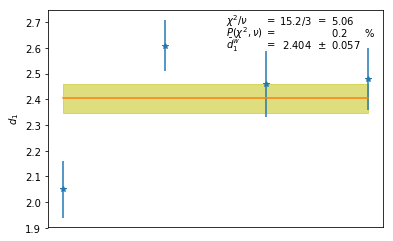

In [12]:
nbi.fitPlot(np.arange(len(d_1)),d_1,e_1,lambda x,*p: p[0]*np.ones_like(x),
            [wa_1],np.array([ew_1]),
            nsig=2,pnames=[r"\bar d_1^w"],data_kw={'fmt':'*'},ylabel="$d_1$")
plt.xticks([]);

Clearly, these 4 measurements are _not_ consistent within uncertainties. However, we observe that the first measurement ($2.05\pm0.11$) is an outlier of the sample, so if we recalculate the weighted average, uncertainty, and resulting $\chi^2$ _without_ the first point, we find that 

In [13]:
wa_2 = np.average(d_1[1:],weights=1/np.array(e_1[1:])**2)
ew_2 = 1/np.sqrt((1/np.array(e_1[1:])**2).sum())
printRes(r'\bar d^{w,no}_1',wa_2,[ew_2],1)

<IPython.core.display.Math object>

In [14]:
chi2_2,nu_2 = nbi.chi2nu(np.arange(len(d_1[1:])),d_1[1:],
                         lambda x,*p: wa_2, [0], e_1[1:])
printRes(r'\chi^2/\nu={:.1f}/{}'.format(chi2_2,nu_2),chi2_2/nu_2,None,2)

<IPython.core.display.Math object>

In [15]:
pchi2_2 = 100*sp.stats.chi2.sf(chi2_2,nu_2)
printRes(r'P_{{\chi^2}}({:.1f},{})'.format(chi2_2,nu_2),pchi2_2,None,3,unit='\%')

<IPython.core.display.Math object>

which clearly indicates that the 3 last measurements _are_ consistent within uncertainties.  Let us plot this again 

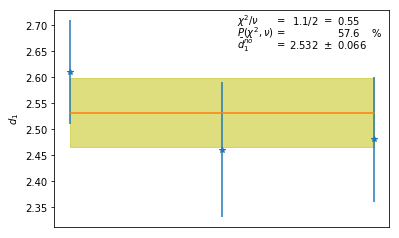

In [16]:
nbi.fitPlot(np.arange(len(d_1[1:])),d_1[1:],e_1[1:],
            lambda x,*p: p[0]*np.ones_like(x),
            [wa_2],np.array([ew_2]),
            nsig=2,pnames=[r"\bar d_1^{no}"],
            data_kw={'fmt':'*'},
            ylabel="$d_1$")
plt.xticks([]);

The residuals 

$$r_{1,i} = \frac{|d_{1,i} - \bar d|}{s_d}\quad,$$

where 

\begin{align*}
  \bar d_1 &= \frac1N\sum_{i=1}^N d_i\\
  s^2_{d_1} &= \frac1{N-1}\sum_{i=1}^N (d_{1,i}-\bar d_1)^2\quad,
\end{align*}
  
are the sample mean and square _unbiased_ sample standard devivation, respectively, can be evaluated, and compared to the probability of normal random variable having the same value or larger to possibly classify a measurement as an _outlier_.  The criterion (according to Chauvenet's criterion) for an outlier is then that the _expected_ number of observations with $r>r_{1,i}$ satisfy

$$ E[n|r>r_{1,i}]=n\,P_N(|x|>r_{1,i}) = n(1 - 2F_N(r_{1,i})) < 0.5\quad,$$

were $n$ is the sample size, and $F_N$ is the cumulative distribution function for the _normal_ distribution. Let's evaluate this for the full sample 

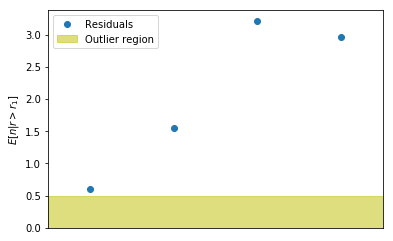

In [17]:
plt.fill_between(np.arange(6)-1,.5,color='y',alpha=.5,
                label="Outlier region")
plt.plot(np.arange(4),
         len(d_1)*2*sp.stats.norm.sf(np.abs(d_1-np.mean(d_1))/np.std(d_1,ddof=1)),
         'o',label="Residuals")
plt.xticks([])
plt.xlim([-.5,3.5])
plt.ylim(0)
plt.ylabel(r"$E[n|r>r_1$]")
plt.legend();

We see that, according to this criterion, that _none_ of the measurements can be classified as outliers.  However, if we choose the _biased_ sample standard deviation for $s_d$, we find that the first _can_ be classifed as an outlier.  

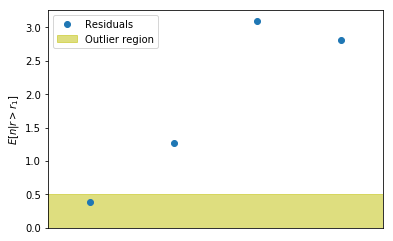

In [18]:
plt.fill_between(np.arange(6)-1,.5,color='y',alpha=.5,
                label="Outlier region")
plt.plot(np.arange(4),
         len(d_1)*2*sp.stats.norm.sf(np.abs(d_1-np.mean(d_1))/np.std(d_1)),
         'o',label="Residuals")
plt.xticks([])
plt.xlim([-.5,3.5])
plt.ylim(0)
plt.ylabel(r"$E[n|r>r_{1}]$")
plt.legend();

However, we should be weary of outright discarding this measurement in our continued analysis.   Most likely, the uncertainty of this measurement has been underestimated. What we _can_ say is 

- Including all measurements _with_ uncertainties we find that the measurements are _not_ compatible within the uncertainties.  
- However, _if_ we discard the first measurement on the grounds of the Chauvenet criterion for outliers, we find that the measurements _are_ compatible within uncertainties.

We furthermore have another data set which do _not_ include uncertainties.  

In [19]:
d_2 = [2.69,2.71,2.56,2.48,2.34,2.79,2.54,2.68,2.69,2.58,2.66,2.70]

We calculate the mean and the uncertainty on the mean 

\begin{align*}
  \bar d_2 &= \frac1{N}\sum_{i=1}^{N} d_{2,i}\\
  \delta_{\bar d_2} &= \frac{s_{d_2}}{\sqrt{N}} = \frac1{\sqrt{N}(N-1)}\sqrt{\sum_{i=1}^{N} (d_{2,i}-\bar d_2)^2}
\end{align*}

this sample

In [20]:
av_1 = np.mean(d_2)
ea_1 = np.std(d_2,ddof=1)/np.sqrt(len(d_2))
printRes(r'\bar d_2', av_1, [ea_1], 1)

<IPython.core.display.Math object>

By construction, all the measurements of $d_2$ agree with this sample mean within the uncertainties.  Let's plot the fit as before 

In [21]:
nbi.fitPlot(np.arange(len(d_2)),d_2,np.zeros_like(d_2),
            lambda x,*p: p[0]*np.ones_like(x),
            [av_1],np.array([ea_1]),
            nsig=2,pnames=[r"\bar d_2"],
            data_kw={'fmt':'*'},
            ylabel="$d_2$")
plt.xticks([]);

where $\chi^2=0$ since the sample $d_2$ has no uncertainties.   Likewise, we can perform a test for outliers as we did before for the weighted sample 

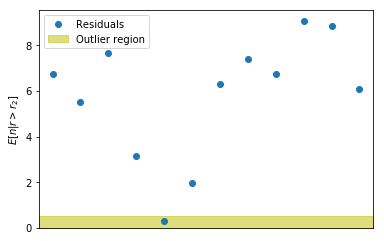

In [22]:
plt.fill_between(np.arange(len(d_2)+2)-1,.5,color='y',alpha=.5,
                label="Outlier region")
plt.plot(np.arange(len(d_2)),
         len(d_2)*2*sp.stats.norm.sf(np.abs(d_2-av_1)/np.std(d_2,ddof=1)),
         'o',label="Residuals")
plt.xticks([])
plt.xlim([-.5,len(d_2)-.5])
plt.ylim(0)
plt.ylabel(r"$E[n|r>r_{2}]$")
plt.legend();

and we see that the $5^{\mathrm{th}}$ point $2.34$ can be classified as an outlier.   If we exclude that point from the calculation of the sample mean we find 

In [23]:
av_2 = np.mean(d_2[:3]+d_2[5:])
ea_2 = np.std(d_2[:3]+d_2[5:])/np.sqrt(len(d_2)-1)
printRes(r'\bar d_2^{no}', av_2, [ea_2], 1)

<IPython.core.display.Math object>

We thus have the following measurements of the depth of the tumor

In [24]:
aa = [av_2, av_1, wa_2, wa_1]
ee = [ea_2, ea_1, ew_2, ew_1]
a1 = np.average([wa_1, av_1],weights=1/np.power([ew_1,ea_1],2))
e1 = 1/np.sqrt((1/np.power([ew_1,ea_1],2)).sum())
a2 = np.average([wa_2, av_2],weights=1/np.power([ew_2,ea_2],2))
e2 = 1/np.sqrt((1/np.power([ew_2,ea_2],2)).sum())
plt.fill_between([a1-e1,a1+e1],[-1,-1],[4,4],
                 color='y',alpha=.5,label=r'$\bar d_1^w$ and $\bar d_2$')
plt.fill_between([a2-e2,a2+e2],[-1,-1],[4,4],
                 color='r',alpha=.4,label=r'$\bar d_1^{w,no}$ and $\bar d_2^{no}$')
plt.errorbar(aa,np.arange(len(aa)),np.zeros_like(aa),ee,fmt="*")
plt.yticks(np.arange(len(aa)),
           [r"$\bar d_2^{no}$",
            r"$\bar d_2$",
            r"$\bar d_1^{w,no}$",
            r"$\bar d_1^w$"])
plt.ylim([-.5,3.5])
plt.legend(loc='lower left');

Of these the most _precise_ is $\bar d_2^{no}$.  Which of these is the most _accurate_ cannot be determined as the _true_ depth of the tumor is not known.   Thus, $\bar d_2^{no}$, with the least statistical uncertainty, could be _systematically_ off from the true value, while $\bar d_1^{w}$ could suffer less of these systematic uncertainties and be more _accurate_.  

In the abscense of knowledge of the true value, our best value is given by combining the measurements of the two samples - either _with_ or _without_ outliers.  Given the arbitrary nature of selecting outliers, we default to combining the results of the two samples including _all_ data points, and we calculate the weighted average and uncertainty of $\bar d_1^w$ and $\bar d_2$ to obtain our final estimatew of the tumor depth as 

In [25]:
printRes('d',a1,[e1],1)

<IPython.core.display.Math object>

As a side note, had we excluded the outliers we would get 

In [26]:
printRes('d^{no}',a2,[e2],1)

<IPython.core.display.Math object>

## Spectral radiance

The spectrial radiance $B$ is given by Planck's law for given frequency $\nu$ and temperature $T$

$$
B(\nu,T) = \frac{2h\nu^3}{c^2} \frac{1}{e^{\frac{h\nu}{kT}}-1}\quad,
$$

where $h$ and $k$ are Planck and Boltzman's constants, respectively, and $c$ is the speed of light

In [27]:
display(printRes('h',sp.constants.h,None,10,-34,'Js'),
        printRes('c',sp.constants.c,None,10,8,'m/s'),
        printRes('k',sp.constants.k,None,10,-23,"J/K"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Thus $B$ has units of 

In [28]:
J,s,m,K = sy.symbols("J s m K")
sy.simplify(J*s * 1/s**3 / (m/s)**2)

Let us implement this expression symbolically

In [29]:
nu, T, h, c, k = sy.symbols("nu T h c k")
B = sy.Lambda((nu,T,h,c,k),2*h*nu**3/c**2/(sy.exp(h*nu/(k*T))-1))

If we have measured $\nu$ and $T$ we may want to calculate the $B$ from these, propagating the uncertainties of the measurement to the final value of $B$. Propagation of uncertainty can be thought of the matrix product 

$$
  \mathbf{J}^T\mathbf{V}\mathbf{J}\quad,
$$

where 

\begin{align*}
  J &= \begin{bmatrix} \frac{\partial B}{\partial \nu}\\ \frac{\partial B}{\partial \nu}\end{bmatrix}
  &
  V &= \begin{bmatrix} \delta_\nu^2 & \rho_{\rho T}\delta_\nu\delta_T\\
    \rho_{\rho T}\delta_\nu\delta_T & \delta_T^2\end{bmatrix}\quad,
\end{align*}

where $\delta_\nu,\delta_T$ are the uncertainties on $\nu$ and $T$ respectively, and $\rho$ is the correlation of $\nu$ and $T$. 

Let us evaluate this this matrix product 

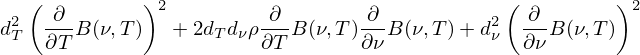

In [30]:
dnu, dT, rho = sy.symbols("d_nu d_T rho")
BB = sy.Function("B")(nu,T)
J = sy.Matrix([[sy.diff(BB,nu)],[sy.diff(BB,T)]])
V = sy.Matrix([[dnu**2, rho*dnu*dT],
               [rho*dnu*dT, dT**2]])
sy.simplify(J.T * V * J)[0]

Thus we need to evaluate the differentials 

\begin{align*} 
  \frac{\partial B}{\partial\nu} & & \frac{\partial B}{\partial T}
\end{align*}

to evaluate the uncertainty on $B$ as

\begin{align*}
  \delta^2_B &= \left[\frac{\partial B}{\partial \nu}\delta_\nu\right]^2 + \left[\frac{\partial B}{\partial T}\delta_T\right]^2 + 2\frac{\partial B}{\partial \nu}\frac{\partial B}{\partial T}\delta_\nu\delta_T\rho_{\nu T}\quad.
\end{align*} 

Let us evaluate the derivatives.  First with respect to $\nu$

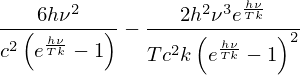

In [31]:
dBnu = sy.Lambda((nu,T,h,c,k), sy.diff(B(nu,T,h,c,k),nu))
dBnu.expr

Then with respect to $T$

In [32]:
dBT = sy.Lambda((nu,T,h,c,k),sy.diff(B(nu,T,h,c,k),T))
dBT.expr

With 
\begin{align*}
  \nu &= (0.556\pm0.025)\times10^{15} 1/\mathrm{s}\\
  T &= (5.50\pm0.29)\times10^{3} K\quad,
\end{align*}

where the uncertainties on $\nu$ and $T$ are uncorrelated we find the spectral radiance to be 

In [33]:
def Bnum(nu,T,h=sp.constants.h,c=sp.constants.c,k=sp.constants.k):
    return float(B(nu,T,h,c,k))
def dBnum(nu,T,dnu,dT,rho=0,h=sp.constants.h,c=sp.constants.c,k=sp.constants.k):
    d1 = dBnu(nu,T,h,c,k)
    d2 = dBT(nu,T,h,c,k)
    return np.sqrt(float(d1**2*dnu**2 + d2**2*dT**2 + 2*rho*d1*d2*dnu*dT))
nu1 = 0.556e15
T1  = 5.5e3
B1 = Bnum(nu1,T1)
eB1 = dBnum(nu1,T1,0.025e15,0.29e3)
printRes('B',B1,[eB1],2,True,'Jm^{-2}')

<IPython.core.display.Math object>

Note, if we use the values 

\begin{align*}
  h &= 6.626\times10^{-34} && \mathrm{Js}\\
  c &= 2.997\times10^8 && \mathrm{m/s}\\
  k &= 1.381\times10^{-23} && \mathrm{J/K}\quad,
\end{align*}

as given in the question, and write out the values _incorrect_ as for example

    0.566*10**15 
    
instead of `0.566e15`, we get (because of rounding errors) 

In [34]:
bnu, bdnu = 0.566*10**15, 0.025*10**15
bT, bdT = 5.5*10**3, 0.29*10**3
bh = 6.626*10**-34
bc = 2.997*10**8
bk = 1.381*10**-23
bB1 = Bnum(bnu,bT,bh,bc,bk)
beB1 = dBnum(bnu,bT,bdnu,bdT,0,bh,bc,bk)
printRes('B',bB1,[beB1],2,True,'Jm^{-2}')

<IPython.core.display.Math object>

If the correlation between $\nu$ and $T$ is 

$$\rho_{\nu T} = 0.87\quad,$$

the uncertainty on $B$ becomes 

In [35]:
eB2 = dBnum(nu1,T1,0.025e15,0.29e3,0.87)
printRes('B',B1,[eB2],2,True,'Jm^{-2}')

<IPython.core.display.Math object>

# Monte Carlo (random numbers from a distribution):

The PDF $f$ is defined as 

$$ f(x) = C(1-e^{-ax})\quad,$$

over the domain $x\in[0,2]$ and with $a=2$.  For this to be a PDF, we must require that 

$$\int_0^2 \mathrm{d}x\,f(x) = 1\quad,$$ 

which allows us to evaluate $C$.  First, let us calculate the integral

In [36]:
C, x = sy.symbols("C x")
a = sy.symbols("a",positive=True)
f = sy.Lambda(x, C*(1-sy.exp(-a*x)))
I = sy.simplify(sy.integrate(f(x),(x,0,2)))
I

Let us solve this for $C$ and evauuate for $a=2$

In [37]:
CC = float(sy.solve(I-1,C)[0].evalf(subs={a:2}))
printRes('C',CC,None,5)

<IPython.core.display.Math object>

To answer the question what is the mean of the above distribution, we must evaluate 

$$
\mu = \operatorname{E}[x] = \int_0^2 \mathrm{d}x\, xf(x)\quad,
$$

which we will do symbolically

In [38]:
mu = sy.integrate(x*f(x),(x,0,2))
mu.evalf(subs={a:2,C:CC}).round(5)

The root-mean-square if given by the square root of the expectation value of $x^2$ 

$$
\operatorname{RMS}[x] = \sqrt{\operatorname{E}[x^2]} = \sqrt{\int_0^2 \mathrm{d}x\,x^2f(x)}\quad,
$$

which evaluate in the same way

In [39]:
rms2 = sy.integrate(x**2*f(x),(x,0,2))
sy.sqrt(rms2).evalf(subs={a:2,C:CC}).round(5)

The _variance_ of $f$, on the other hand, is given by the expectation value of $(x-\mu)^2$ 

$$
\operatorname{Var}[X] = \operatorname{E}[(x-\mu)^2] = \int_0^2 \mathrm{d}x\,(x-\mu)^2 f(x)\quad,
$$
which simplifies to 
$$
\operatorname{Var}[X] = \operatorname{RMS}^2[x] - \operatorname{E}^2[x]\quad.
$$
Let us evaluate the standard deviation $\sigma=\sqrt{\operatorname{Var}[x]}$ using the full integral 

In [40]:
var = sy.integrate(sy.simplify(x-mu)**2*f(x),(x,0,2))
sy.sqrt(var).evalf(subs={a:2,C:CC}).round(5)

and then using the RMS formula

In [41]:
sy.sqrt(rms2-mu**2).evalf(subs={a:2,C:CC}).round(5)

To sample $f$ we woud like to calculate the CDF of $f$, given by 

$$F(x) = \int_0^x \mathrm{d}x'\, f(x')\quad,$$

which we may evaluate

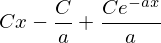

In [42]:
t = sy.symbols("t")
F = sy.Lambda(x, sy.integrate(f(t),(t,0,x)))
F.expr

We would like to find the inverse of this function, so we solve 

$$ y - F(x) = 0\quad,$$

for $x$, and find 

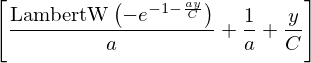

In [43]:
y = sy.symbols("y",real=True)
hh = sy.solve(y-F(x),x)
hh

We can thus define the quantile function $h(y) = F^{-1}(x)$ 

In [44]:
h = sy.Lambda(y,hh[0])

and use that to draw random numbers by sampling a random uniform variable $Y\sim U$, and evaluate $h$ there.  To see this we plot a random sample and the PDF. 

*Note*: We fix the random number seed for reproducibility. 

In [45]:
np.random.seed(123456)
u = np.random.uniform(0,1,500)
r = [float(h(uu).evalf(subs={a:2,C:CC})) for uu in u]
xd = np.linspace(0,2,100)
fy = [float(f(xx).evalf(subs={a:2,C:CC})) for xx in xd]

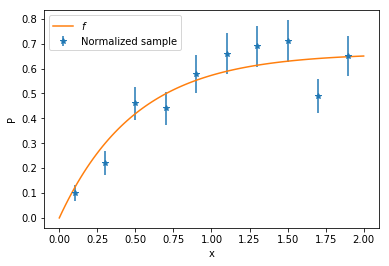

In [46]:
cnt, mid, widths, uncer = nbi.histogram(r,10,(0,2),normalize=True)
plt.errorbar(mid,cnt,uncer,fmt='*',label='Normalized sample')
plt.plot(xd,fy,label=r'$f$')
plt.xlabel('x')
plt.ylabel("P")
plt.legend();

Let us fit the function $f$ to our sample, leaving $a$ as a free parameter.  

In [47]:
def numF(x,*a,C=CC):
    return CC*(1-np.exp(-a[0]*x))

p, cov = sp.optimize.curve_fit(numF,mid,cnt,[1],sigma=uncer)

plt.plot(xd,fy,'--g',label='$f$')
nbi.fitPlot(mid,cnt,uncer,numF,p,cov,pnames=[r"a"],nsig=2,
            xlabel='x', ylabel='P',
            tbl_kw={'loc':'center right'},
            data_kw={'fmt':'*','label':'Sample'},
            band_kw={'label':'Confidence band'},
            fit_kw={'label':'Fit','lw':4},
            leg_kw={'loc':'lower right'});

We see the fit to the sample gives us a reduced $\chi^2$ of roughly 1.

Let $Y$ be the random variable defined as the sum of five random variables $X\sim f$.  We will test if this random variable is approximately normal distributed.  We do that by sampling $Y$ 1000 times, histogram the sample and fit a normal distribution to the sample. 

In [48]:
u = np.random.uniform(0,1,(1000,5))
r = [np.sum([float(h(uuu).evalf(subs={a:2,C:CC})) for uuu in uu]) for uu in u]

In [49]:
cnt, mid, widths, uncer = nbi.histogram(r,25,normalize=False)

def normF(x,*p):
    A = p[2]
    mu = p[0]
    sigma = p[1]
    return A/np.sqrt(2*np.pi)/sigma*np.exp(-0.5*(x-mu)**2/sigma**2)

p, cov = sp.optimize.curve_fit(normF,mid[uncer!=0],cnt[uncer!=0],
                               [np.mean(r),np.std(r),len(r)],
                               sigma=uncer[uncer!=0],
                              absolute_sigma=True)

nbi.fitPlot(mid,cnt,uncer,normF,p,cov,pnames=[r"\mu",r"\sigma","A"],nsig=1,
            xlabel='x', ylabel='P',
            tbl_kw={'loc':'lower center'},
            data_kw={'fmt':'*','label':'Sample'},
            band_kw={'label':'Confidence band'},
            fit_kw={'label':'Fit','lw':4},
            leg_kw={'loc':'best'});

The hypothesis that $Y\sim N$ seems relatively substantiated by the above fit with a probability of roughly $50\%$

# Statistical tests

## UFOs

Let's read in the supplied data

In [50]:
table = np.genfromtxt('data_UfoSightings.txt',delimiter='\t',skip_header=3,names=True,
                      dtype=['U10',float,int,int,'U2',float,'U10',float])

Let us get the sample of durations indicated by the key `DurationInSec`

In [51]:
dur = table['DurationInSec']

We plot this distribution and calculate the mean and median

In [52]:
meant = dur.mean()
medt = np.median(dur)
n, _, _ = plt.hist(dur,bins=np.logspace(0,np.log10(dur.max()),15),
                   label=r'$t$ distribution')
plt.plot([meant,meant],[0,n.max()*1.1],"--",
         label=r'$\bar t={:.1f}$'.format(meant))
plt.plot([medt,medt],[0,n.max()*1.1],"--",
         label=r'Median $t={:.1f}$'.format(medt))
plt.xscale("log")
plt.xlabel(r'$t$')
plt.legend();

To check if there's a difference between East and West coast observations, we plot the distribution of durations for each coast 

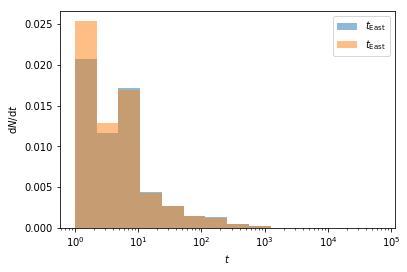

In [53]:
durEast = table[table['UScoast']==2]['DurationInSec']
durWest = table[table['UScoast']==1]['DurationInSec']
bins = np.logspace(0,np.log10(dur.max()),15)
plt.hist(durEast,bins=bins,density=True,label=r'$t_{\mathrm{East}}$',alpha=.5)
plt.hist(durWest,bins=bins,density=True,label=r'$t_{\mathrm{East}}$',alpha=.5)
plt.xscale("log")
plt.xlabel('$t$')
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}t$')
plt.legend();

Off-hand the two distributions look alike.  But we will perform a quantitative Kolmogorov-Smirnov test to see if this is indeed the case 

In [54]:
ks, prob = sp.stats.ks_2samp(durEast, durWest)
printRes('P(\mathrm{East}\sim\mathrm{West})',100*prob,None,1,unit='\%')

<IPython.core.display.Math object>

To see if there's any correlation between the season and the time of day of the observations, we plot those two quantities against each other and calculate the correlation coefficient.

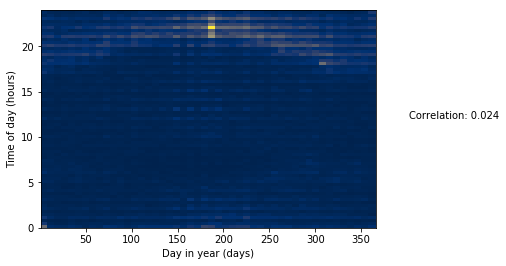

In [55]:
plt.hist2d(table['DayInYear'],table['HourInDay'],cmap='cividis',bins=[48,72]);
plt.xlabel('Day in year (days)')
plt.ylabel('Time of day (hours)')
c = np.corrcoef(table['DayInYear'],table['HourInDay'])[0,1]
plt.text(1.1,.5,'Correlation: {:.3f}'.format(c),transform=plt.gca().transAxes);

The observations are clearly clustered around summer and late in the evening (23:00 or so).   Also one see a roughly sinusal band of correlation between the time of year and the time of day.   Thus we see the observations predominently happen shortly after sunset, and very few in the dead of night or during the day. 

Next, we look at West coast observations and the distribution over the week days.  Thus, we look at the distribution of observations on the West coast as a function of the the weekday (Monday through Sunday)

In [56]:
bc = np.arange(7)
n,_ = np.histogram(table[table['UScoast']==1]['DayOfWeek'],
                   len(bc),[bc[0]-.5,bc[-1]+.5])
mn = n.mean()
en = n.std()/np.sqrt(len(n))
plt.bar(bc,n,alpha=.7)
plt.errorbar(bc,n,np.sqrt(n),fmt='.')
plt.fill_between([bc[0]-.5,bc[-1]+.5],[mn-en,mn-en],[mn+en,mn+en],
                 color='y',alpha=.5)
plt.plot([bc[0]-.5,bc[-1]+.5],[mn,mn],'--',label='Mean')
plt.xticks(bc,['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.xlabel('Day of week')
plt.ylabel('Number of observations on the West coast')
plt.legend();

We see a clear peak in the number of observations on Saturdays and in general an enhancement of observations during the week-end (Friday to Sunday).   Thus, the number of observations is clearly _not_ uniform over the week. 

To quantify this a bit more, we calculate the average over the distribution and the $\chi^2$ of the sample with respect to this average, and evaluate the probability

In [57]:
pchiall = sp.stats.chi2.sf(*nbi.chi2nu(np.arange(7),n,
                           lambda x,*p:np.ones_like(x)*n.mean(),
                           [0],np.sqrt(n)))*100
printRes(r'P_{{\chi^2}}(N_{\mathrm{week}}\sim U)',pchiall,None,3,True,unit='\%')

<IPython.core.display.Math object>

indicating a very low probability that the distribution is uniform. 


If we only consider Monday through Thursday, then the picture is different.  Again, we calculate the $\chi^2$ probability with respect to the mean of the same 

In [58]:
bc = np.arange(4)
n,_ = np.histogram(table[np.logical_and(table['UScoast']==1,
                                        table['DayOfWeek']<4)]['DayOfWeek'],
                   len(bc),[bc[0]-.5,bc[-1]+.5])
mn = n.mean()
en = n.std()/np.sqrt(len(n))
plt.bar(bc,n,alpha=.7)
plt.errorbar(bc,n,np.sqrt(n),fmt='.')
plt.fill_between([bc[0]-.5,bc[-1]+.5],[mn-en,mn-en],[mn+en,mn+en],
                 color='y',alpha=.5)
plt.plot([bc[0]-.5,bc[-1]+.5],[mn,mn],'--',label='Mean')
plt.xticks(bc,['Mon','Tue','Wed','Thu'])
plt.xlabel('Day of week')
plt.ylabel('Number of observations on the West coast')
plt.legend();
p = sp.stats.chi2.sf(*nbi.chi2nu(np.arange(4),n,
                                 lambda x,*p:np.ones_like(x)*n.mean(),
                                 [0],np.sqrt(n)))*100
plt.text(1.1,.95,r'$P_{{\chi^2}}={:.1f}\%$'.format(p),
         transform=plt.gca().transAxes);

Thus, the number of observations from Monday to Thurdsay are more compatible with a uniform distribution.  However, as we have many observations, it is clear that there's a small bias towards Wednesdays on the West coast. 

## Fairness of die

We have 12 _dice_ that we want to check for fairness.  In each throw we roll all 12 dice and count the number of 5's and 6's, resulting in the following distribution

In [59]:
n56 = np.arange(13)
m56 = [185, 1149, 3265, 5475, 6114, 5194, 3067, 1331, 403, 105, 14, 4, 0]
plt.bar(n56,m56,label='Times 5 or 6 was rolled in a single throw')
plt.xlabel("$N_{56}$ - number of 5 or 6's")
plt.legend();

Since the probability of a 5 or 6 ($1/3$) of each _die_ is independent of each other, and independent for each throw, we clearly have that $N_{56}\sim B(12,1/3)$ (Binomial with 12 trials, and probability of success $1/3$). 

Let us test the hypothesis that $N_{56}~B(12,1/3)$ by calculating $\chi^2$ with respect to the hyposthesis.  

In [60]:
nbi.fitPlot(n56,m56,np.sqrt(m56),
            lambda n,*p:np.sum(m56)*sp.stats.binom.pmf(n,12,*p),
            [1/3],None,band=False,nsig=2,
            data_kw={'fmt':'o','label':'Data'},
            fit_kw={'marker':'*','lw':0,'label':r'$B(12,1/3)$'},
            leg_kw={'loc':'center right'},
            tbl_kw={'loc':'upper right'});

We see that the $\chi^2$ probablity that $N_{56}\sim B(12,1/3)$ is very small, and we must reject this hypothesis.

Let us try to fit a Binomial distribution to the data, but leaving the single success probablity a free parameter. 

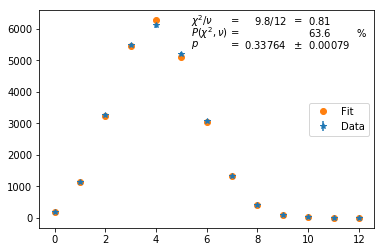

In [61]:
def h(x,*p):
    return np.sum(m56)*sp.stats.binom.pmf(x,12,p[0])

p, cov = sp.optimize.curve_fit(h,n56[:-1],m56[:-1],[1/3],
                               sigma=np.sqrt(m56[:-1]))

nbi.fitPlot(n56,m56,np.sqrt(m56),h,p,cov,pnames=["p"],
            nsig=2,band=False,
            data_kw={'fmt':'*','label':'Data'},
            fit_kw={'linewidth':0,'marker':'o','label':'Fit'},
            leg_kw={'loc':'center right'});

and we see that we must reject the hypothesis of fair dice and accept that the dice are loaded with 

In [62]:
printRes(r'\Delta p={:.4}-1/3'.format(p[0]),(p[0]-1/3)*100,None,1,unit='\%')

<IPython.core.display.Math object>

different to obtain 5 or 6 on each die. 

# Fitting data - spectrum

Let's read in the data and visualize it

In [63]:
data = np.genfromtxt('data_GammaSpectrum.txt')
nb = int((data.max()-data.min())/2)
dcc, cc, wcc, edcc = nbi.histogram(data,nb)
plt.errorbar(cc,dcc,edcc,label=r'$\gamma$-ray intensity')
plt.xlabel('Channel')
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}c$')
plt.legend();

Here, we have quiet purposely binned the data in wide bins (2 channels) so that the peaks stand out over the background.  Let us differentiate the spectrum to find the peaks.  We plot the differentiation

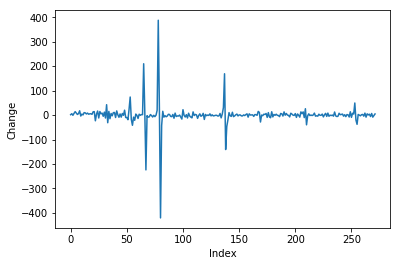

In [64]:
diffdc = np.diff(dcc)
plt.plot(diffdc)
plt.xlabel('Index')
plt.ylabel('Change');

We see that the peaks correspond to the channels where the change is large, and we know that in the low end of the spectrum we must have 3 peaks.  So let's limit the range to roughly 50% of the range and investigate the change

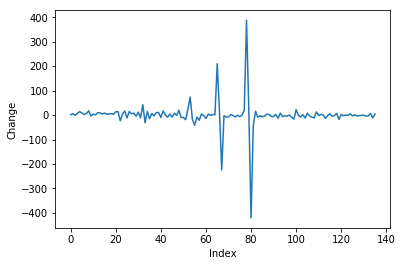

In [65]:
diffdc = diffdc[:int(len(diffdc)/2)]
plt.plot(diffdc)
plt.xlabel('Index')
plt.ylabel('Change');

In this range we're searching for three peaks.  So let's find the threshold so that we can get the location of those three peaks.  

In [66]:
def npeak(t):
    idx = np.argwhere(diffdc > t)
    return len(idx) - 3

t = sp.optimize.brentq(npeak,0,200)
printRes("T",t,None,2,unit='Counts')

<IPython.core.display.Math object>

We have thus found the threshold that allows us to isolate the three peaks. Let's plot the change with the threshold, and the location of the three peaks

In [67]:
ip = np.argwhere(diffdc > t)
plt.plot(diffdc,label="Change")
plt.plot([0,len(diffdc)-1],[t,t],"--",label="Threshold")
plt.plot(ip,diffdc[ip],'*',label='Peaks')
plt.xlabel('Index')
plt.ylabel('Change');
plt.legend();

Thus, we've found the location of the three peaks at 

In [68]:
cp1 = cc[ip.ravel()+1]
display(*[printRes(r'P_{{{}}}'.format(i+1),p,None,4,unit='Channel') 
          for i,p in enumerate(cp1)])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We can thus use this to fit normal distributions to the peaks in the original spectra 

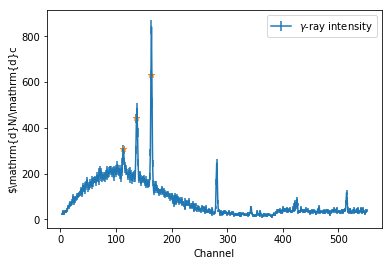

In [69]:
nb = int((data.max()-data.min()))
dc, c, wc, edc = nbi.histogram(data,nb)
plt.errorbar(c,dc,edc,label=r'$\gamma$-ray intensity')
plt.plot(cp1,[dc[np.argwhere(c > p)[0]] for p in cp1],"*")
plt.xlabel('Channel')
plt.ylabel(r'$\mathrm{d}N/\mathrm{d}c')
plt.legend();

near those peaks.   We will fit 

\begin{align*}
  f(x;A,\mu,\sigma,a,b) &= f_p(x;A,\mu,\sigma)+f_b(x;a,b)\\
  &=\frac{A}{\sqrt{2\pi}\sigma}e^{-\frac12\frac{(x-\mu)^2}{\sigma^2}}+a+bx\quad,
\end{align*}

to each of the peaks.

In [70]:
def fp(x,*p):
    return p[2]*np.exp(-1/2*(x-p[0])**2/p[1]**2)/np.sqrt(2*np.pi)/p[1]

def fb(x,*p):
    return p[0]+p[1]*x

def f(x,*p):
    return fp(x,*p[:3])+fb(x,*p[3:])

Since we have 6 parameters in each fit, we will choose at least 18 bins to perform each fit over.  Now let's do the fitting. 

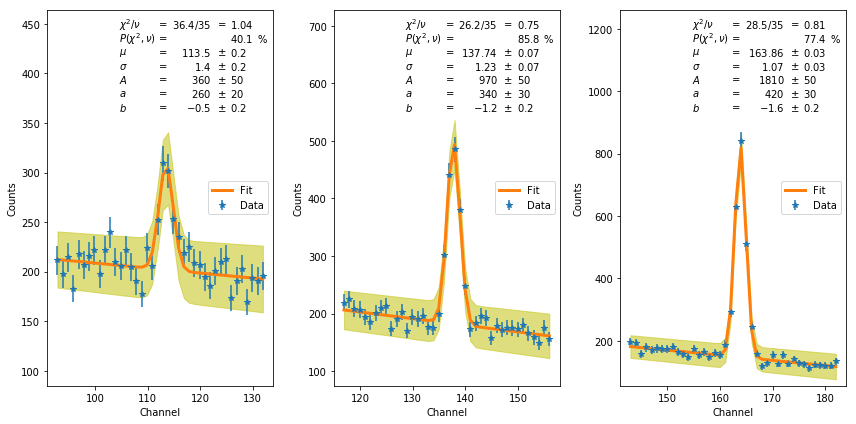

In [71]:
def fitPeaks(cp,c,dc,edc,f,dp=int(20)):
    def one(p,a,c,dc,edc,f,dp):
        idx = np.argwhere(c >= p)[0]
        l1   = int(idx-dp)
        l2   = int(idx+dp)
        lc   = c[l1:l2]
        ldc  = dc[l1:l2]
        ledc = edc[l1:l2]
        p, cov = sp.optimize.curve_fit(f,lc,ldc,
                                       [c[idx][0],1,ldc.max(),lc[-1],-1],
                                       ledc,absolute_sigma=True,
                                       bounds=[[0,0,0,-np.inf,-np.inf],np.inf])
        nbi.fitPlot(lc,ldc,ledc,f,p,cov,nsig=1,axes=a,
                    xlabel='Channel',ylabel='Counts',
                    pnames=['\mu','\sigma','A','a','b'],
                    data_kw={'label':'Data','fmt':'*'},
                    fit_kw={'label':'Fit','linewidth':3},
                    leg_kw={'loc':'center right'})
        a.set_ylim([.5*np.min(ldc),1.5*np.max(ldc)])
        o = np.concatenate((p,np.sqrt(np.diag(cov))))
        return o
    
    nax = 1 if np.isscalar(cp) else len(cp)
    fig, ax = plt.subplots(ncols=nax,figsize=(12,6))
    res = np.empty((0,10))
    
    if nax==1:
        return one(cp,ax,c,dc,edc,f,dp)
    
    for p,a in zip(cp,ax):
        o = one(p,a,c,dc,edc,f,dp)
        res = np.vstack((res,o))
        
    return res
res = fitPeaks(cp1,c,dc,edc,f)
plt.tight_layout()

Thus, we find - with relatively good certainty - the peak positions 

In [72]:
display(*[printRes(r'P_{{{}}}'.format(i),r[0],[r[5]],1,True,unit='Channel')
          for i,r in enumerate(res)])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The relative distance between these peaks 

$$r = \frac{E_3-E_2}{E_2 - E_1}\quad,$$ 

is calculated 

In [73]:
def rel(es):
    return (es[2]-es[1])/(es[1]-es[0])
def erel(es,ees):
    return np.sqrt(((es[1]-es[0])**2*ees[2]**2
            +(es[2]-es[1])**2*ees[0]**2
            +(es[0]-es[2])**2*ees[1]**2)/(es[1]-es[0])**4)
rfit = rel(res[:,0])
erfit = erel(res[:,0],res[:,5])
printRes(r'r_{\mathrm{found}}',rfit, [erfit], 1)

<IPython.core.display.Math object>

and we compare to the relative distance of the known energies 

- 242keV
- 295keV
- 352keV

In [74]:
etab = np.array([242, 295, 352])
rtab = rel(etab)
printRes(r'r_{\mathrm{known}}',rtab, None, 4)

<IPython.core.display.Math object>

and we see that our relative distances found match within the uncertainties. 

Given the found locations of the peaks and the know energy of those peaks, we can estimate (roughly) the conversion function from channel number to energy.  We do that by fitting a straight line to peak channel versus energ

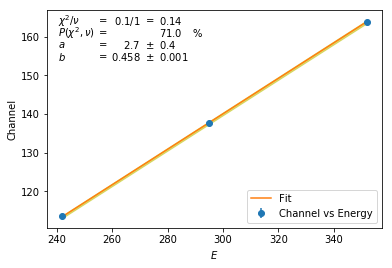

In [75]:
pconv, covconv = nbi.linfit(etab,res[:,0],[lambda x: 1, lambda x: x],res[:,5])
nbi.fitPlot(etab,res[:,0],res[:,5],lambda x,a,b:a+b*x,pconv,covconv,
            pnames=['a','b'],xlabel='$E$', ylabel='Channel',
           data_kw={'label':'Channel vs Energy','fmt':'o'},
           fit_kw={'label':'Fit'},
           tbl_kw={'loc':'upper left'},
           leg_kw={'loc':'lower right'});

Thus, for the p Bizmuth peaks at $609\mathrm{keV}$ and $1120\mathrm{keV}$ we expect to find these near channels

In [76]:
def e2Channel(e,p):
    return p[0]+p[1]*e
etabB = np.array([609,1120])
cp2 = e2Channel(etabB,pconv)
display(*[printRes(r'{}\,\mathrm{{keV}}\rightarrow\mathrm{{Channel}}'.format(ee),
                   cc,None,4) for ee, cc in zip(etabB,cp2)])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let us try to fit the peaks at those position 

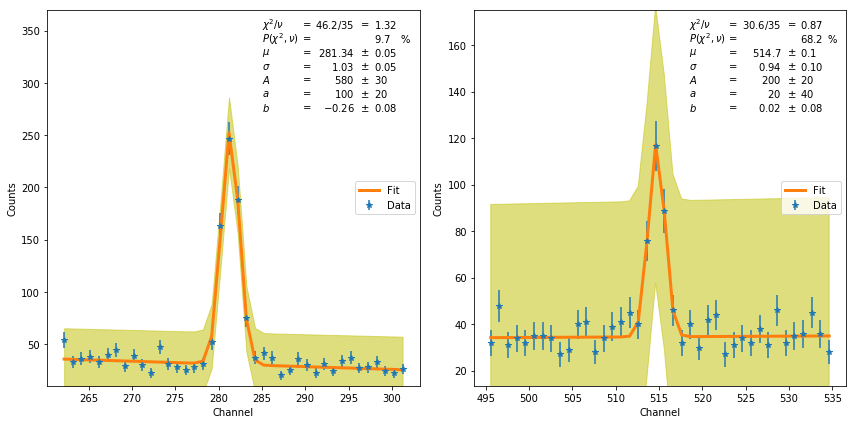

In [77]:
resB = fitPeaks(cp2,c,dc,edc,f)
plt.tight_layout()

We thus have 5 measurements of peaks all with a known energy.  We can thus refine our calibration to check if the response is linear with respect to the energy

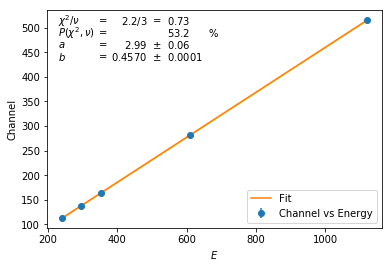

In [78]:
cPeaks = np.concatenate((res[:,0],resB[:,0]))
ecPeaks = np.concatenate((res[:,5],resB[:,5]))
ePeaks = np.concatenate((etab, etabB))
p, cov = nbi.linfit(ePeaks,cPeaks,[lambda x: 1, lambda x: x],ecPeaks)
nbi.fitPlot(ePeaks,cPeaks,ecPeaks,lambda x,a,b:a+b*x,p,cov,
            pnames=['a','b'],xlabel='$E$', ylabel='Channel',
           data_kw={'label':'Channel vs Energy','fmt':'o'},
           fit_kw={'label':'Fit'},
           tbl_kw={'loc':'upper left'},
           leg_kw={'loc':'lower right'});
conv = p

The probability of a linear dependence is high ($\approx 50\%$) and thus we find a linear correspondence between energy and channel number. 

Let us investigate the peak width as a function of energy. In particular, we're interested in if the width is constant with energy (or channel number).  Thus we fit a constant to the determined $\sigma$'s

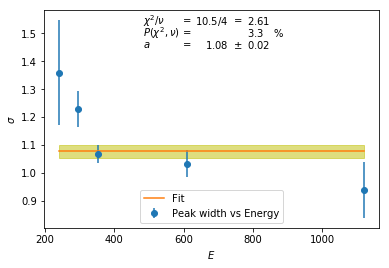

In [79]:
sig = np.concatenate((res[:,1],resB[:,1]))
esig = np.concatenate((res[:,6],resB[:,6]))
p, cov = nbi.linfit(ePeaks,sig,[lambda x: 1],esig)
nbi.fitPlot(ePeaks,sig,esig,lambda x,a:a*np.ones_like(x),p,cov,
            pnames=['a'],xlabel='$E$', ylabel=r'$\sigma$',
           data_kw={'label':'Peak width vs Energy','fmt':'o'},
           fit_kw={'label':'Fit'},
           tbl_kw={'loc':'upper center'},
           leg_kw={'loc':'lower center'});

Thus, we see a relatively low probability of a few percent.  Thus, we must conclude that the peak width resolution is _not_ constant with energy. 

Theoretical calculations predicts a peak in the range $[700,800]\mathrm{keV}$, corresponding to a central channel of 

In [80]:
cp3 = e2Channel(750,conv)
printRes(r'{}\,\mathrm{{keV}}\rightarrow\mathrm{{Channel}}'.format(750),
                   cp3,None,4)

<IPython.core.display.Math object>

We will try to fit a peak to the spectrum in the vicinty of the expected peak 

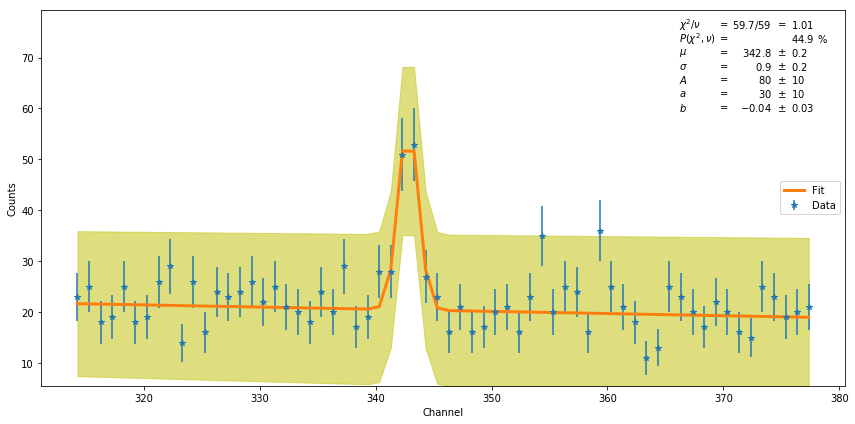

In [81]:
resT = fitPeaks(cp3,c,dc,edc,f,dp=32)
plt.tight_layout()

The probability that we _do_ have a peak is comes out to be high, and thus very likely so, and we have that the number of counts in the peak over the background relative to the uncertainty 

In [82]:
A, dA = nbi.round(resT[2],0), nbi.round(resT[7],0)
printRes(r'5 < \frac{{A}}{{\delta_A}}={:.0f}/{:.0f}'.format(A,dA),A/dA,None,1)

<IPython.core.display.Math object>

and thus we conclude that the peak is indeed significant. 